In [3]:
# Mounting drive
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [149]:
# Unzipping dataset we worked on
!unzip /drive/'My Drive'/retraindata/natural-images.zip -d /content/

Archive:  /drive/My Drive/retraindata/natural-images.zip
replace /content/data/natural_images/airplane/airplane_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

This code is based on two tutorials:

-[Tensorflow DeepDream tutorial](https://www.tensorflow.org/tutorials/generative/deepdream)

-[DeepDream with Tensorflow by Naveen Manwani](https://hackernoon.com/deep-dream-with-tensorflow-a-practical-guide-to-build-your-first-deep-dream-experience-f91df601f479)

Some basic ideas came from various achievements by [Tensorflow Lucid](https://github.com/tensorflow/lucid)

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # Changing google colab to tf 2.x
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.models import Model
from PIL import Image
import PIL
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from scipy.ndimage.filters import gaussian_filter

TensorFlow 2.x selected.


In [0]:
class DeepDreamNetwork:
  # Initialize network, by building the base model, and loading weights
  def __init__(self, model_name, weights_path = None, layer_names = None):
    if model_name == 'InceptionV3':
      self.base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
    
    self.maplist=None
    if weights_path is not None:
      self.base_model.load_weights(weights_path)

    if layer_names is not None:
      self.create_dream_model(layer_names)
    else:
      self.create_dream_model()


  # Normalize an image
  def deprocess(self, img):
    img = 255*(img + 1.0)/2.0
    return tf.cast(img, tf.uint8)


  # Display an image
  def show(self, img):
    plt.figure(figsize=(15,15))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

  
  def create_dream_model(self, names = ['mixed3', 'mixed5']):
    # Maximize the activations of these layers
    layers = [self.base_model.get_layer(name).output for name in names]
    # Create the feature extraction model
    self.dream_model = tf.keras.Model(inputs=self.base_model.input, outputs=layers)

    
  def calc_loss(self, img):
    # Passing through images to retrieve activations, and calculate loss to ascend
    
    # Working without a maplist (guide to dream generation)
    if self.maplist is None:
      img_batch = tf.expand_dims(img, axis=0)
      layer_activations = self.dream_model(img_batch)

      # Working with multiple activated layers
      if len(layer_activations)>1:
        losses = []
        for act in layer_activations:
          losses.append(tf.math.reduce_mean(act))
        return  tf.reduce_sum(losses)
      # Working with 1 activated layer
      else:
        return tf.math.reduce_mean(layer_activations)
    
    # Working with a maplist (guide to dream generation)
    else:
      img_batch = tf.expand_dims(img, axis=0)
      layer_activations = self.dream_model(img_batch)
      
      # Working with multiple activated layers
      if len(layer_activations)>1:
        losses = []
        for i in range(len(layer_activations)):
          # Using the guide activations as weights when calculating loss
          loss=tf.math.reduce_mean(layer_activations[i]*self.maplist[i])
          losses.append(loss)
        return  tf.reduce_sum(losses)
      
      # Working with 1 activated layer
      else:
        # Using the guide activations as weights when calculating loss
        loss=tf.math.reduce_mean(layer_activations[0]*self.maplist[0])
        return loss


  @tf.function
  def deepdream(self, img, step_size):
    with tf.GradientTape() as tape:
      # Watching image and calculating loss based on it
      tape.watch(img)
      loss = self.calc_loss(img)

    # Calculate the gradient of the loss with respect to the pixels of the input image.
    gradients = tape.gradient(loss, img)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 
    
    # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
    # You can update the image by directly adding the gradients (because they're the same shape!)
    img = img + gradients*step_size
    img = tf.clip_by_value(img, -1, 1)

    return loss, img


  @tf.function
  def run_deep_dream_simple(self, img, steps=100, step_size=0.01):
    # Convert from uint8 to the range expected by the model.
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    # Gradient ascent steps
    for step in range(steps):
      loss, img = self.deepdream(img, step_size)
      print(step)
      if step % 100 == 0:
        clear_output(wait=True)
        self.show(self.deprocess(img))
        print ("Step {}, loss {}".format(step, loss))

    # Displaying result
    result = self.deprocess(img)
    clear_output(wait=True)
    self.show(result)
    self.output_img = result

    return result

  def random_roll(self, img, maxroll):
    # Randomly shift the image to avoid tiled boundaries.
    shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
    shift_down, shift_right = shift[0],shift[1] 
    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, img_rolled

  @tf.function
  def get_tiled_gradients(self, img, tile_size=512):
    shift_down, shift_right, img_rolled = self.random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)

    for x in range(max(1,img_rolled.shape[0]//tile_size)):
      for y in range(max(1,img_rolled.shape[1]//tile_size)):
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[x*tile_size:(x+1)*tile_size,
                                y*tile_size:(y+1)*tile_size]
          loss = self.calc_loss(img_tile)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1), -shift_down, axis=0)

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients

  #Applying scales to standard deepdream to achieve better resolution, more details or bigger objects
  def run_deep_dream_with_octaves(self, img, steps_per_octave=100, step_size=0.01, 
                                   num_octaves=3, octave_scale=1.2):
    # Preprocessing
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    for octave in range(num_octaves):
      # Scale the image based on the octave
      if octave>0:
        new_size = tf.cast(tf.convert_to_tensor(img.shape[:2]), tf.float32)*octave_scale
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

      # Gradient ascent steps
      for step in range(steps_per_octave):
        gradients = self.get_tiled_gradients(img)

        # Applying different gaussian filters to gradient,
        # to ensure high and low frequency changes at the same time
        sigma=(step * 4.0) / steps_per_octave + 0.5
        gradients = gaussian_filter(gradients, sigma=sigma*0.5)+\
        gaussian_filter(gradients, sigma=sigma*1)+\
        gaussian_filter(gradients, sigma=sigma*2)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)
        
        if step % 10 == 0:
          clear_output(wait=True)
          self.show(self.deprocess(img))
          print ("Octave {}, Step {}".format(octave, step))
    
    # Visalization
    clear_output(wait=True)
    result = self.deprocess(img)
    self.show(result)

    self.output_img = result

    return result

  # Recursive optimization function starting from the lowest resolution state
  # this method enables rendering HD images while making it possible to have
  # large scale dream objects with high resolution details
  def recursive_optimize(self, image, num_repeats=4, rescale_factor=0.7, blend=0.2,
                       num_iterations=10, step_size=0.0001):
    if num_repeats>0:

      # Downscale the image.  
      sigma = 0.5
      img_blur = gaussian_filter(image, sigma=(sigma, sigma, 0.0))
      new_size = tf.cast(tf.convert_to_tensor(image.shape[:2]), tf.float32)*rescale_factor
      img_downscaled = tf.image.resize(image, tf.cast(new_size, tf.int32))
            
      # Recursive call to this function.
      # Subtract one from num_repeats and use the downscaled image.
      img_result = self.recursive_optimize(img_downscaled,
                                      num_repeats=num_repeats-1,
                                      rescale_factor=rescale_factor,
                                      blend=blend,
                                      num_iterations=num_iterations,
                                      step_size=step_size)

      # Blending the new, blurred dreamy image with the original  
      new_size = tf.cast(tf.convert_to_tensor(image.shape[:2]), tf.float32)
      img_upscaled = tf.image.resize(img_result, tf.cast(new_size, tf.int32))
      image = blend * image + (1.0 - blend) * img_upscaled
      print("Recursive level:", num_repeats)

    # Gradient ascent
    for step in range(num_iterations[num_repeats]):
      gradients = self.get_tiled_gradients(image)
      
      # Gradients are smoothened again
      sigma=(step * 4.0) / num_iterations[num_repeats] + 0.5
      gradients = gaussian_filter(gradients, sigma=sigma*0.5)+\
      gaussian_filter(gradients, sigma=sigma*1)+gaussian_filter(gradients, sigma=sigma*2)
      image = image + gradients*step_size

      image = tf.clip_by_value(image, -1, 1)
      if step % 10 == 0:
        clear_output(wait=True)
        self.show(self.deprocess(image))
    
    return image


  # Generating guide activations for guided dreams
  def gen_maplist(self, img=None):
    # If no guide is presend, reset maplist
    if img is None:
        self.maplist = None
        return None
    
    # Running the image through the dream model
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    imgin = tf.expand_dims(img, axis=0)
    preds = self.dream_model.predict(imgin)
    self.maplist = []
    
    # Normalizing and gathering sums of activations
    if len(preds) == 1:
      predsums=np.sum(preds, axis=(0,1,2))
      self.maplist.append((predsums-np.min(predsums))/(np.max(predsums)-np.min(predsums)))
      return self.maplist

    for pred in preds:
      predsums=np.sum(pred, axis=(0,1,2))
      self.maplist.append((predsums-np.min(predsums))/(np.max(predsums)-np.min(predsums)))
    return self.maplist

In [0]:
# Creating network object, with Inception V3 model and mixed 2 as output.
# Mixed 2 is used to extract relatively low level information.
DDNetwork = DeepDreamNetwork('InceptionV3', None, ['mixed2'])

<class 'numpy.ndarray'>


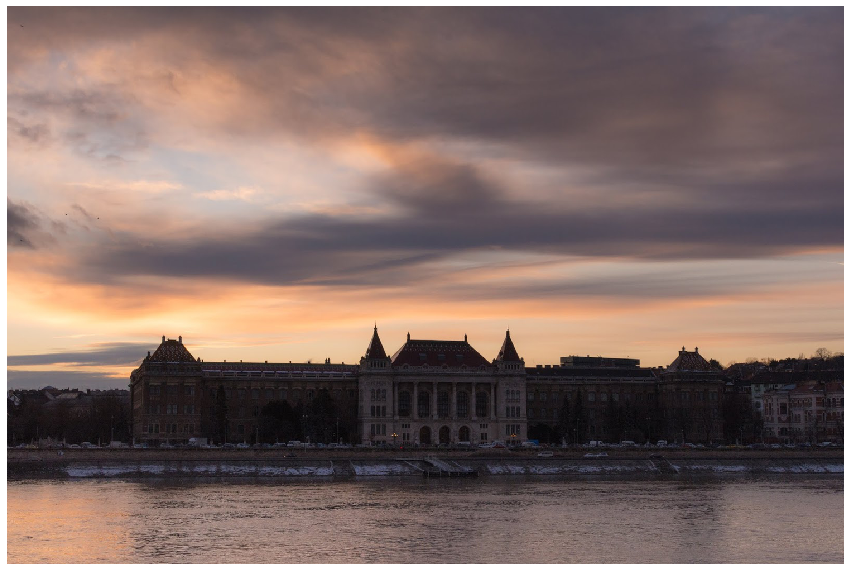

In [146]:
#Loading image and restricting it's maximal size
img=Image.open('./bme.jpg')
img.load()
maxsize = (1500,1500)
img.thumbnail(maxsize, Image.ANTIALIAS)
original_img = np.asarray( img, dtype="int32" )[:,:,:3]
print(type(original_img))
DDNetwork.show(original_img)

<class 'numpy.ndarray'>


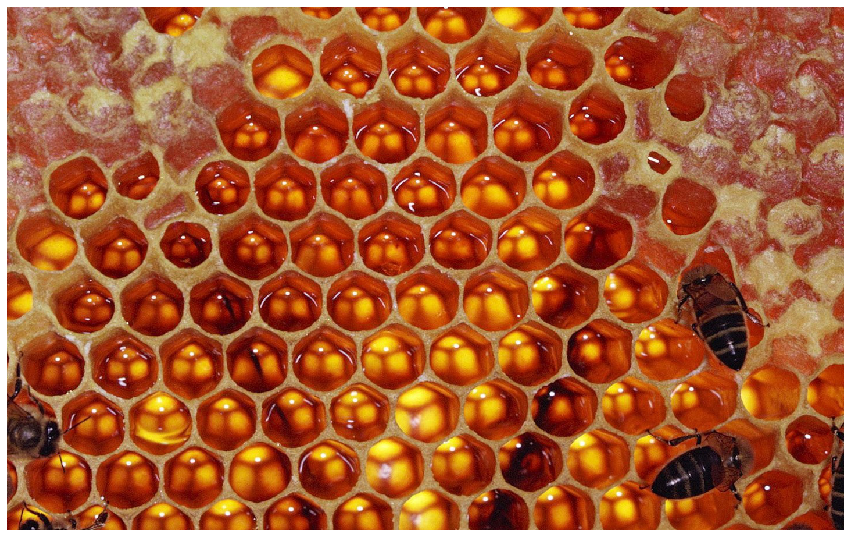

In [147]:
#Loading guide image
baseimg=Image.open('./beehive.jpg')
baseimg.load()
maxsize = (1500,1500)
baseimg.thumbnail(maxsize, Image.ANTIALIAS)
base = np.asarray( baseimg, dtype="int32" )[:,:,:3]
print(type(base))
DDNetwork.show(base)

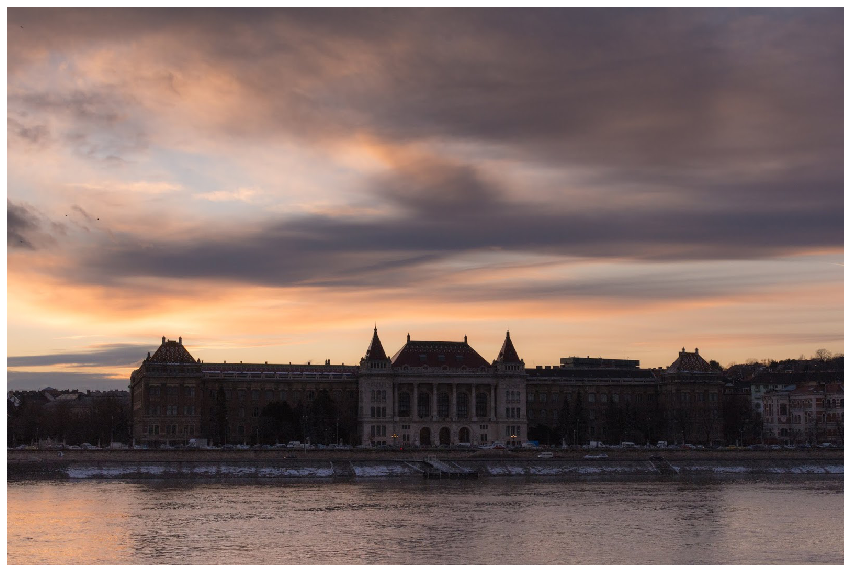

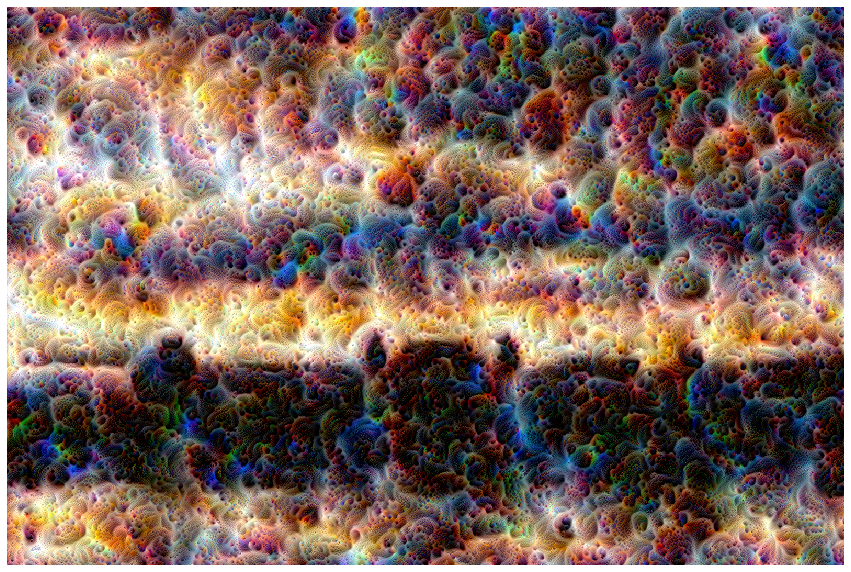

In [145]:
# Generating guide activations

DDNetwork.gen_maplist(baseimg)

# Sometimes using a tanh function on these weights is effective, it wasn't in
# our last usecase, but we leave it in as an option to try
#DDNetwork.maplist=[np.tanh(m*2-1) for m in DDNetwork.maplist]

# Preprocessing original image
img = tf.keras.preprocessing.image.img_to_array(original_img)
img = tf.keras.applications.inception_v3.preprocess_input(img)

# Running optimization
dream_img = DDNetwork.recursive_optimize(img,
                       num_repeats=3, rescale_factor=0.5, blend=0.15,
                       num_iterations=[100,50,30,30], step_size=0.04)

# Display output
dream_img=DDNetwork.deprocess(dream_img)
clear_output()
DDNetwork.show(original_img)
DDNetwork.show(dream_img)

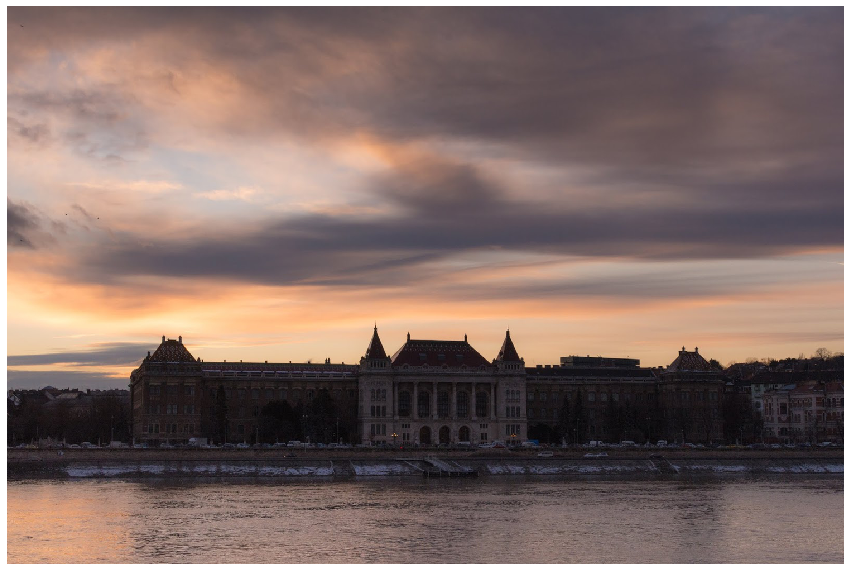

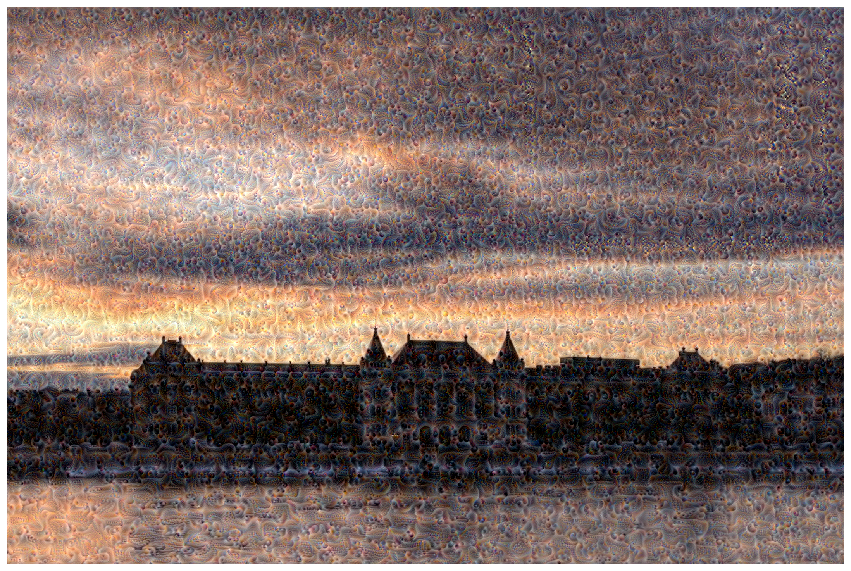

In [155]:
# Running original DeepDream as pointed out in Tensorflow's DeepDream tutorial

# Reset guide activations
DDNetwork.gen_maplist()

dream_img = DDNetwork.run_deep_dream_with_octaves(img=img, step_size=0.025, 
                                                  steps_per_octave = 20)

clear_output()
DDNetwork.show(img)
DDNetwork.show(DDNetwork.output_img)